In [ ]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import linprog
import networkx as nx

In [ ]:
# coords for supply locations (airports)
s_nodes = np.array([(5.51808, 95.4173),
(3.6312, 98.87507),
(4.14369, 96.12811),
(5.18116, 97.14132),
(5.0877, 95.36713),
(4.54189, 95.71732),
(5.8926, 95.32376)])

# airport capacity by supply type and location
s = np.array([
    [13090, 18000],
    [4050, 6800],
    [300, 800],
    [7300, 6050],
    [550, 650],
    [13500, 4550],
    [5000, 6900]
])

# coords for demand locations (response zones)
d_nodes = np.array([(5.54829, 95.32375),
(5.8926, 95.32376),
(5.45291, 95.47778),
(4.52241, 97.61142),
(5.10864, 96.66381),
(5.15569, 97.10363),
(4.97863, 97.22214),
(4.23288, 98.00288),
(4.47253, 97.97563),
(3.30886, 97.69822),
(2.35894, 97.87216),
(2.64397, 96.02557),
(3.3115, 97.35165),
(3.95516, 97.35165),
(3.79634, 97.00683),
(4.44826, 96.83509),
(4.12484, 96.49297),
(4.45427, 96.15269),
(5.07426, 95.94097),
(4.78736, 95.64579),])


# response zone requirements (determined by population density)
# by item type and location
d = np.array([
    [2880, 2880], [230, 230], [2230, 2230], [2720, 2720], [4040, 4040],
     [3260, 3260], [4850, 4850], [2330, 2330], [2750, 2750], [1270, 1270],
      [580, 580], [150, 150], [1560, 1560], [430, 430], [900, 900],
       [1290, 1290], [820, 820], [4390, 4390], [5550, 5550], [1430, 1430]
])

# number of helicopters per supply location
h = np.array([33,7,2,13,5,12,15])
# total transport capacity
t = h*2500

# ensure dimensions match
assert s_nodes.shape[0] == s.shape[0]
assert d_nodes.shape[0] == d.shape[0]
assert s.shape[1] == d.shape[1]
assert t.shape[0] == s_nodes.shape[0]

# sanity checks
assert np.all(np.sum(s, axis=0) >= np.sum(d, axis=0))

m = s.shape[0] # number of supply locations
n = d.shape[0] # number of demand locations
r = s.shape[1] # number of supply types

print("m="+str(m)+" n="+str(n)+" r="+str(r))

m=7 n=20 r=2


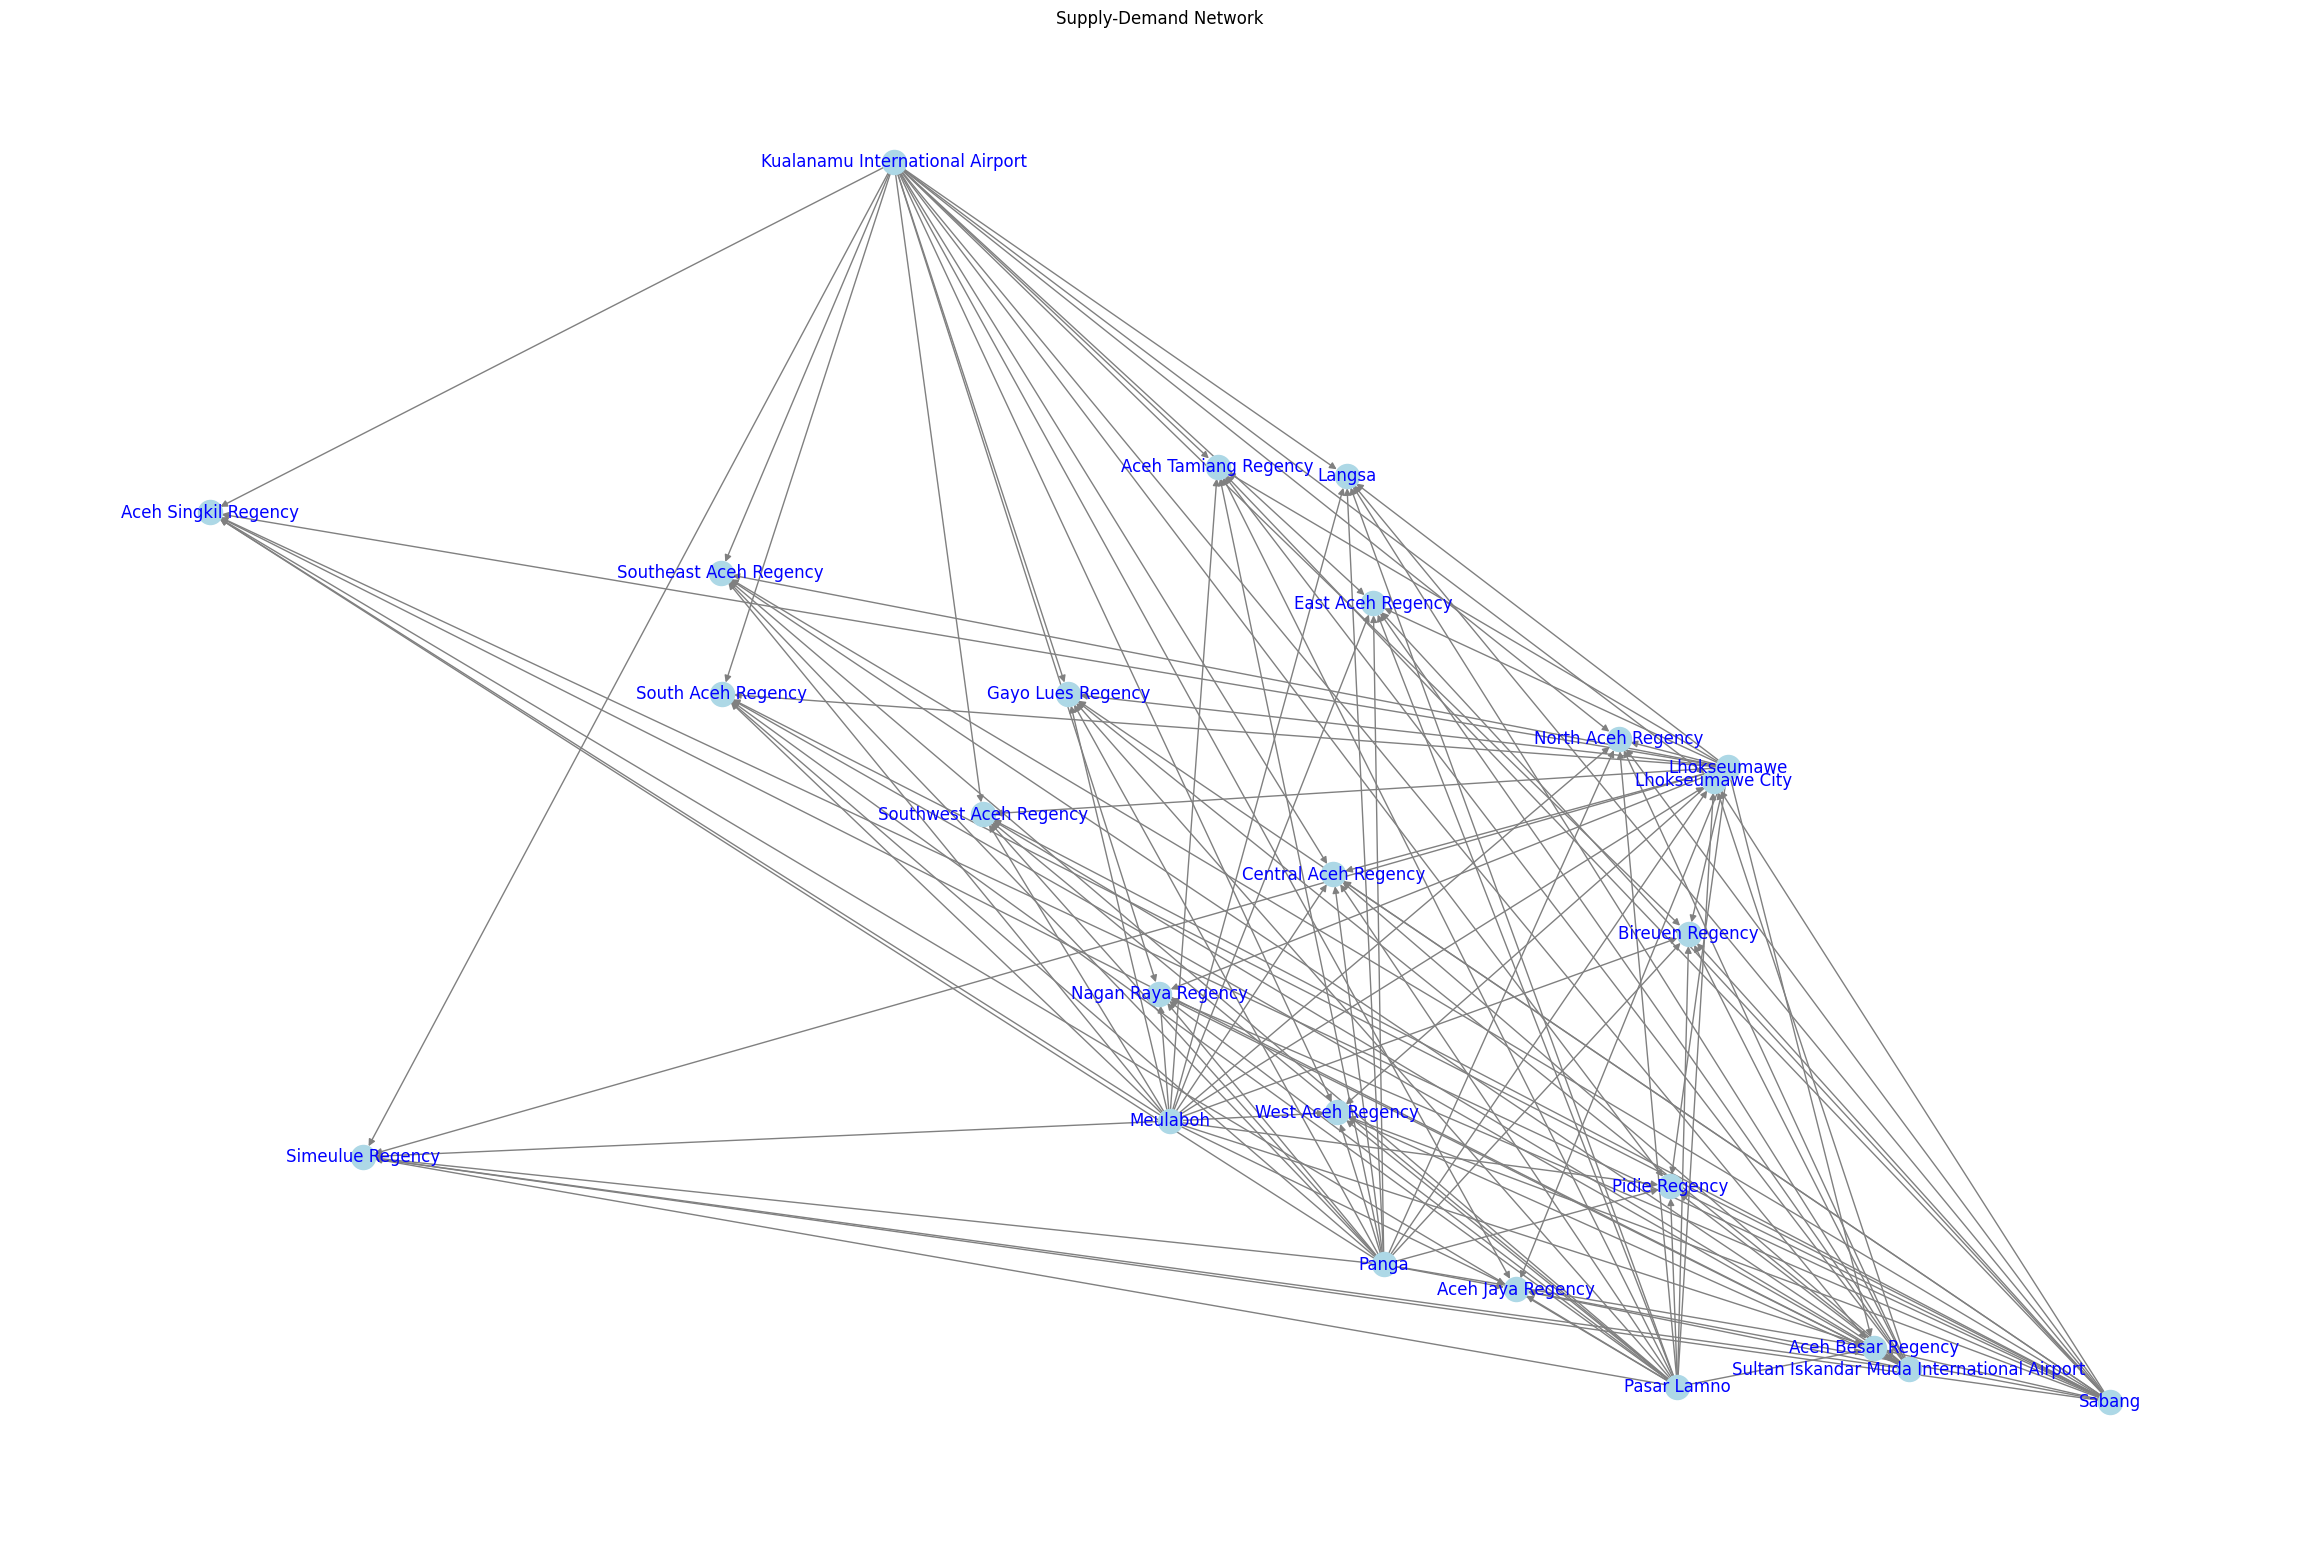

In [ ]:
### Supply and Demand Network

supply_nodes = [
    'Sultan Iskandar Muda International Airport',
    'Kualanamu International Airport',
    'Meulaboh',
    'Lhokseumawe',
    'Pasar Lamno',
    'Panga',
    'Sabang',
]

demand_nodes = [
    'Aceh Besar Regency',
    'East Aceh Regency',
    'Bireuen Regency',
    'Lhokseumawe City',
    'North Aceh Regency',
    'Aceh Tamiang Regency',
    'Langsa',
    'Southeast Aceh Regency',
    'Aceh Singkil Regency',
    'Simeulue Regency',
    'South Aceh Regency',
    'Gayo Lues Regency',
    'Southwest Aceh Regency',
    'Central Aceh Regency',
    'Nagan Raya Regency',
    'West Aceh Regency',
    'Pidie Regency',
    'Aceh Jaya Regency'
]

nodes = [supply_nodes, demand_nodes]

coordinates = {'Sultan Iskandar Muda International Airport': (5.51808,95.4173),
               'Kualanamu International Airport': (3.6312,98.87507),
               'Meulaboh': (4.14369,96.12811),
               'Lhokseumawe': (5.18116,97.14132),
               'Pasar Lamno': (5.0877,95.36713),
               'Panga': (4.54189,95.71732),
               'Sabang': (5.8926,95.32376),
               'Aceh Besar Regency': (5.45291,95.47778),
               'East Aceh Regency': (4.52241,97.61142),
               'Bireuen Regency': (5.10864,96.66381),
               'Lhokseumawe City': (5.15569,97.10363),
               'North Aceh Regency': (4.97863,97.22214),
               'Aceh Tamiang Regency': (4.23288,98.00288),
               'Langsa': (4.47253,97.97563),
               'Southeast Aceh Regency': (3.30886,97.69822),
               'Aceh Singkil Regency': (2.35894,97.87216),
               'Simeulue Regency': (2.64397,96.02557),
               'South Aceh Regency': (3.3115,97.35165),
               'Gayo Lues Regency': (3.95516,97.35165),
               'Southwest Aceh Regency': (3.79634,97.00683),
               'Central Aceh Regency': (4.44826,96.83509),
               'Nagan Raya Regency': (4.12484,96.49297),
               'West Aceh Regency': (4.45427,96.15269),
               'Pidie Regency': (5.07426,95.94097),
               'Aceh Jaya Regency': (4.78736,95.64579)}

edges = [(supply, demand) for supply in supply_nodes for demand in demand_nodes]

# Create the graph
G = nx.DiGraph()
nodes = supply_nodes + demand_nodes  # Combine all nodes
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Plot the graph
plt.figure(figsize=(23, 15))
nx.draw(G, pos=coordinates, with_labels=True, node_color='lightblue', edge_color='gray', font_color='blue', font_size=12, arrows=True)
plt.title("Supply-Demand Network")
plt.grid(True)
plt.show()

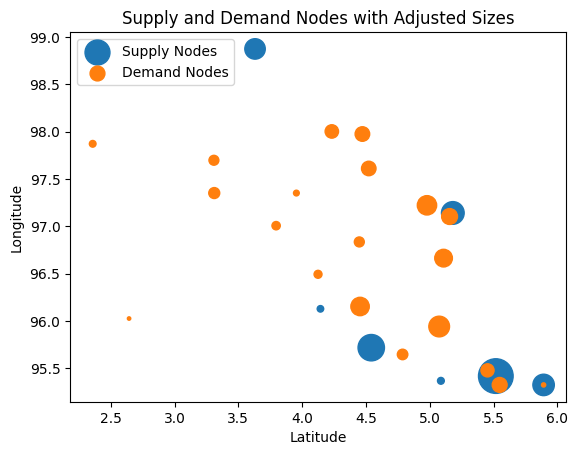

In [ ]:
# Plot with smaller point sizes
plt.scatter(s_nodes[:, 0], s_nodes[:, 1], s=0.02*s.sum(axis=1), label='Supply Nodes')
plt.scatter(d_nodes[:, 0], d_nodes[:, 1], s=0.02*d.sum(axis=1), label='Demand Nodes')

# Add legend and display plot
plt.legend(loc='upper left')
plt.title('Supply and Demand Nodes with Adjusted Sizes')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()


In [ ]:
# transport costs (currently using distance) from each s_i to each d_j
C = np.linalg.norm(d_nodes[np.newaxis, :, :] - s_nodes[:, np.newaxis,:], axis=2)
print(C)

[[0.0983069  0.38602456 0.08890984 2.40946495 1.31203212 1.72482909
  1.88373399 2.88737995 2.76373428 3.17541321 4.00081281 2.93777138
  2.93440032 2.48685119 2.34328706 1.77613156 1.7601658  1.29324791
  0.6864448  0.76561047]
 [4.03572891 4.2101939  3.85489386 1.5463074  2.65941718 2.33710707
  2.1325443  1.05959153 1.23159591 1.22019629 1.62002283 3.01567129
  1.55660418 1.5574847  1.87552444 2.19752257 2.4327106  2.84408106
  3.26976528 3.43000806]
 [1.61860933 1.92501042 1.4618434  1.53089431 1.10367703 1.40562558
  1.37623633 1.87689036 1.87655693 1.77825379 2.49540437 1.50322138
  1.47972644 1.23797968 0.9448814  0.76979452 0.36534661 0.31155114
  0.94920067 0.80432807]
 [1.85427753 1.95183791 1.68558992 0.80928708 0.48298546 0.04548909
  0.21806025 1.2812184  1.09463677 1.95336758 2.91531351 2.77168381
  1.88145349 1.24391105 1.39133533 0.79430424 1.23942312 1.22709346
  1.20510071 1.54650846]
 [0.46262833 0.80606759 0.3816042  2.31438769 1.29684907 1.73783051
  1.85821376 2.7

In [ ]:
# how much aid in kg to deliver along each route
X = cp.Variable((m,n,r))
# minimize total transport distance while meeting constraints
obj = cp.Minimize(cp.sum(cp.multiply(np.dstack([C]*r),X)))
# limit amount of each item each supply location can send
constraint1 = [cp.sum(X[i,:,k]) <= s[i,k] for i in range(m) for k in range(r)]
# limit amount of each item each demand location can receive
constraint2 = [cp.sum(X[:,j,k]) >= d[j,k] for j in range(n) for k in range(r)]
# no sending negative amounts
constraint3 = [X >= 0]
# limit aid deliveries to not exceed transport capacity for each supply location
constraint4 = [cp.sum(cp.multiply(np.dstack([C]*r),X)[i,:,:]) <= t[i] for i in range(m)]

constraints = constraint1 + constraint2 + constraint3 + constraint4
prob = cp.Problem(obj, constraints)

In [ ]:
prob.solve()

/usr/local/lib/python3.11/dist-packages/cvxpy/reductions/solvers/solving_chain.py:418: UserWarning: The problem has an expression with dimension greater than 2. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(


84948.91845715084

In [ ]:
X.value.round(3)

array([[[2880.   , 2530.   ],
        [   0.   ,    0.   ],
        [2230.   , 2230.   ],
        [   0.   , 2720.   ],
        [2430.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,  430.   ],
        [   0.   ,    0.   ],
        [   0.   , 1290.   ],
        [   0.   ,    0.   ],
        [   0.   , 2470.   ],
        [5550.   , 5550.   ],
        [   0.   ,  780.   ]],

       [[  -0.   ,   -0.   ],
        [  -0.   ,   -0.   ],
        [  -0.   ,   -0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        [2330.   , 2330.   ],
        [   0.   , 2620.   ],
        [1140.   , 1270.   ],
        [ 580.   ,  580.   ],
        [   0.   ,    0.   ],
        [   0.   ,    0.   ],
        

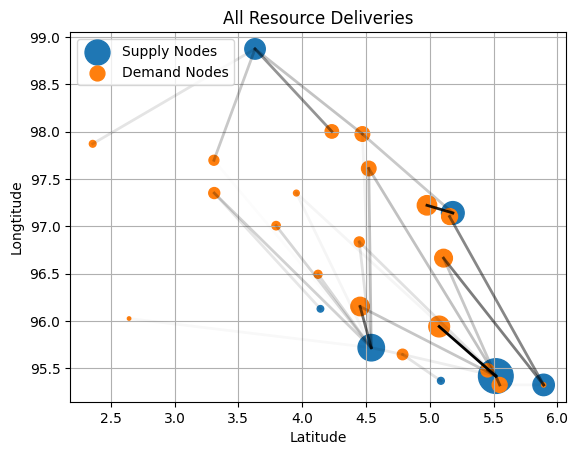

In [ ]:
plt.scatter(s_nodes[:,0],s_nodes[:,1],s=0.02*s.sum(axis=1))
plt.scatter(d_nodes[:,0],d_nodes[:,1],s=0.02*d.sum(axis=1))
max_X = np.sum(X.value, axis=2).max()

for i in range(m):
    for j in range(n):
        plt.plot(
            [s_nodes[i,0],d_nodes[j,0]],
            [s_nodes[i,1],d_nodes[j,1]],
            c='k',
            lw=2,
            alpha=np.sum(np.abs(X.value[i,j]))/max_X
        )

plt.legend(['Supply Nodes','Demand Nodes'],loc='upper left')
plt.grid(True)
plt.xlabel('Latitude')
plt.ylabel('Longtitude')
plt.title('All Resource Deliveries')
plt.show()

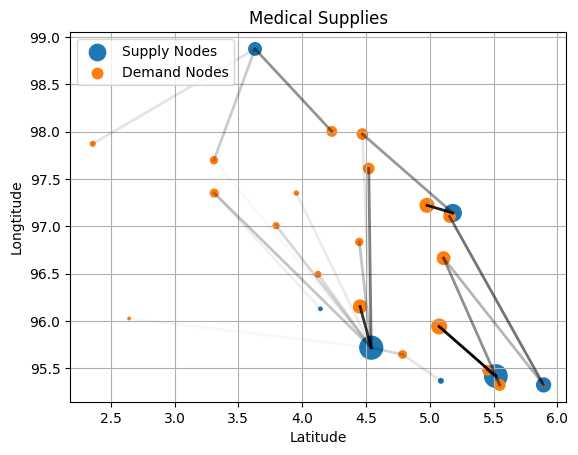

In [ ]:
# Sum for the first resource type

plt.scatter(s_nodes[:,0],s_nodes[:,1],s=0.02*s[:,0])
plt.scatter(d_nodes[:,0],d_nodes[:,1],s=0.02*d[:,0])
max_X = X.value[:,:,0].max()

for i in range(m):
    for j in range(n):
        plt.plot(
            [s_nodes[i,0],d_nodes[j,0]],
            [s_nodes[i,1],d_nodes[j,1]],
            c='k',
            lw=2,
            alpha=np.abs(X.value[i,j,0])/max_X
        )

plt.legend(['Supply Nodes','Demand Nodes'],loc='upper left')
plt.grid(True)
plt.xlabel('Latitude')
plt.ylabel('Longtitude')
plt.title('Medical Supplies')
plt.show()

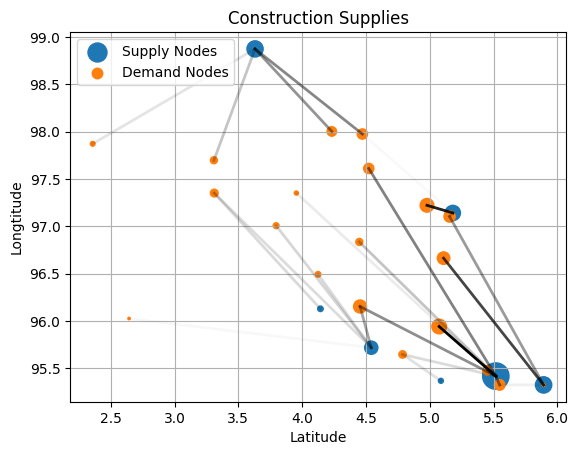

In [ ]:
# Sum for the second resource type

plt.scatter(s_nodes[:,0],s_nodes[:,1],s=0.02*s[:,1])
plt.scatter(d_nodes[:,0],d_nodes[:,1],s=0.02*d[:,1])
max_X = X.value[:,:,1].max()

for i in range(m):
    for j in range(n):
        plt.plot(
            [s_nodes[i,0],d_nodes[j,0]],
            [s_nodes[i,1],d_nodes[j,1]],
            c='k',
            lw=2,
            alpha=np.abs(X.value[i,j,1])/max_X
        )

plt.legend(['Supply Nodes','Demand Nodes'],loc='upper left')
plt.grid(True)
plt.xlabel('Latitude')
plt.ylabel('Longtitude')
plt.title('Construction Supplies')
plt.show()